In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch.nn as nn
import torch.optim as optim
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 for CvT model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48, 0.47, 0.42], std=[0.226, 0.225, 0.227])  # ImageNet normalization
])


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
from transformers import AutoModelForImageClassification
from transformers import AutoImageProcessor
import torch
import torch.nn as nn
import torch.optim as optim

model_name = "microsoft/beit-base-patch16-224"
num_classes = 12

# Load base model
modelAgriculturePest = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

# Replace classifier
modelAgriculturePest.classifier = nn.Linear(
    modelAgriculturePest.classifier.in_features,
    num_classes
)

modelAgriculturePest.to(device)

optimizer = optim.Adam(modelAgriculturePest.parameters(), lr=1e-4)

# Load checkpoint safely
checkpoint_path = "/content/drive/MyDrive/AgriculturalPests/AgriculturalPests_beit_model.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# ✅ Try loading as pure state_dict
try:
    modelAgriculturePest.load_state_dict(checkpoint)
    print("Loaded model weights successfully (state_dict only).")
except RuntimeError:
    # fallback
    modelAgriculturePest.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("Loaded full training checkpoint.")

modelAgriculturePest.eval()
feature_extractorAgri = AutoImageProcessor.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([12]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and 

Loaded model weights successfully (state_dict only).


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

# Your pest class labels (must match training order)
class_namesA = [
    'ants', 'earthworms', 'earwig', 'grasshopper',
    'moth', 'snail', 'wasp', 'weevil'
]

def predict_agriPest(
    image_path,
    model,
    feature_extractor,
    device,
    show=False
):
    """
    Predict agricultural pest from an image.

    Args:
        image_path (str): Path to input image
        model (torch.nn.Module): Trained BEiT model
        feature_extractor: HuggingFace feature extractor
        device (torch.device): CPU or CUDA
        show (bool): If True, display image with prediction

    Returns:
        predicted_label (str): Pest class name
        confidence (float): Prediction confidence
    """

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()

    # Inference
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        confidence, predicted_class_id = torch.max(probs, dim=1)

    predicted_label = class_namesA[predicted_class_id.item()]
    confidence = confidence.item()

    # Optional visualization
    if show:
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}")
        plt.axis("off")
        plt.show()

    return predicted_label, confidence


In [ ]:
#Load Models
from transformers import AutoModelForImageClassification
from transformers import AutoImageProcessor
import torch.nn as nn
import torch.optim as optim
import torch

# Define model again
model_name = "nvidia/mit-b0"
modelCrop = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=4,
    ignore_mismatched_sizes=True
)

# Redefine classifier layer
num_classes = 5
modelCrop.classifier = nn.Linear(modelCrop.classifier.in_features, num_classes)

# Move to device

modelCrop.to(device)

# Redefine optimizer
optimizer = optim.Adam(modelCrop.parameters(), lr=1e-4)

# Load checkpoint
checkpoint = torch.load('/content/drive/MyDrive/smartagriculture/cropModel.pth', map_location=device)

modelCrop.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

start_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']

# Set model to eval or train mode as needed
modelCrop.eval()  # or model.train()
feature_extractorCrop = AutoImageProcessor.from_pretrained(model_name)


Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'reduce_labels'
  image_processor = cls(**image_processor_dict)


In [ ]:
crop_class_names = [
    "jute",
    "maize",
    "rice",
    "sugarcane",
    "wheat"
]

In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

def predict_crop(
    image_path,
    model,
    feature_extractor,
    device,
    show=False
):
    """
    Predict crop type from an image.

    Args:
        image_path (str): Path to crop image
        model (torch.nn.Module): Trained crop classification model
        feature_extractor: HuggingFace image processor
        device (torch.device): CPU or CUDA
        show (bool): Display image with prediction

    Returns:
        predicted_label (str): Crop name
        confidence (float): Prediction confidence
    """

    # Load image
    image = Image.open(image_path).convert("RGB")

    # Preprocess
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()

    # Inference
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        confidence, predicted_class_id = torch.max(probs, dim=1)

    predicted_label = crop_class_names[predicted_class_id.item()]
    confidence = confidence.item()

    # Optional visualization
    if show:
        plt.imshow(image)
        plt.title(f"Predicted Crop: {predicted_label}\nConfidence: {confidence:.2f}")
        plt.axis("off")
        plt.show()

    return predicted_label, confidence


In [ ]:
import os

test_dir = "/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/"

image_namesAgripest = []
test_imagesAgripest = []

if not os.path.exists(test_dir):
    print(f"Directory does not exist: {test_dir}")
else:
    for img_name in sorted(os.listdir(test_dir)):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(test_dir, img_name)
            test_imagesAgripest.append(img_path)
            image_namesAgripest.append(img_name)

print(f"Total AgriPest images loaded: {len(test_imagesAgripest)}")


Total AgriPest images loaded: 8


In [ ]:
test_imagesAgripest

['/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/Weevil (283).jpg',
 '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/ants (300).jpg',
 '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/earthworms (181).jpg',
 '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/earwig (272).jpg',
 '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/grasshopper (250).jpg',
 '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/moth (280).jpg',
 '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/snail (270).jpg',
 '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/wasp (769).jpg']

In [ ]:
import os

test_dir = "/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/"

image_namesCrop = []
test_imagesCrop = []

if not os.path.exists(test_dir):
    print(f"Directory does not exist: {test_dir}")
else:
    for img_name in sorted(os.listdir(test_dir)):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(test_dir, img_name)
            test_imagesCrop.append(img_path)
            image_namesCrop.append(img_name)

print(f"Total AgriPest images loaded: {len(test_imagesCrop)}")


Total AgriPest images loaded: 5


In [ ]:
test_imagesCrop

['/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/jute001a.jpeg',
 '/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/maize001a.jpeg',
 '/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/rice001a.jpeg',
 '/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/sugarcane006a.jpeg',
 '/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/wheat003.jpeg']

In [21]:
def LLMmodule(predictedAgriPest, predictedCrop):
    """
    Smart Agriculture Decision Support Module:
    Generates human suggestions and IoT signals based on pest-crop relationship.

    Args:
        predictedAgriPest (str): Detected pest
        predictedCrop (str): Detected crop

    Returns:
        dict: {
            "human_suggestions": list of strings,
            "IoT_signals": dict of device actions
        }
    """

    human_suggestions = []

    # --- Pest general actions ---
    pest_actions = {
        "ants": "Apply targeted ant bait; monitor aphid populations.",
        "weevil": "Use neem-based sprays and remove affected plant parts.",
        "grasshopper": "Use barrier nets or organic pesticide sprays early morning.",
        "moth": "Install pheromone traps; apply Bacillus thuringiensis (Bt) if larvae are present.",
        "earwig": "Handpick or use traps if infestation is heavy.",
        "snail": "Apply iron phosphate baits or remove manually.",
        "slug": "Use traps or copper barriers; maintain dry soil surface.",
        "earthworms": "Beneficial for soil; monitor soil health.",
        "wasp": "Beneficial predator; monitor ecosystem."
    }

    # --- Crop-specific actions ---
    crop_actions = {
        "jute": "Maintain moderate irrigation; mulch to retain moisture.",
        "maize": "Ensure proper spacing; monitor for stem borers.",
        "rice": "Check water levels; use pheromone traps for pests.",
        "sugarcane": "Regularly remove weeds; monitor for borers.",
        "wheat": "Maintain soil fertility; monitor for aphids."
    }

    # --- Pest × Crop sensitivity mapping ---
    # Values: High / Moderate / Low / Beneficial
    crop_sensitivity = {
        "ants": {"rice": "Moderate", "wheat": "Low"},
        "weevil": {"maize": "High", "rice": "High"},
        "grasshopper": {"jute": "High", "maize": "High", "sugarcane": "Moderate"},
        "moth": {"rice": "High", "maize": "Moderate", "sugarcane": "High"},
        "snail": {"rice": "Moderate", "sugarcane": "Moderate", "jute": "Low"},
        "slug": {"rice": "Moderate", "jute": "Low"},
        "earwig": {"wheat": "Low", "jute": "Low"},
        "earthworms": {"all": "Beneficial"},
        "wasp": {"all": "Beneficial"}
    }

    # --- Generate human suggestions ---
    human_suggestions.append(f"For pest '{predictedAgriPest}': {pest_actions.get(predictedAgriPest, 'Monitor regularly.')}")
    human_suggestions.append(f"For crop '{predictedCrop}': {crop_actions.get(predictedCrop, 'Maintain regular crop management.')}")

    # Add crop-specific pest risk
    pest_risk = crop_sensitivity.get(predictedAgriPest, {}).get(predictedCrop, "Unknown")
    if pest_risk != "Unknown":
        human_suggestions.append(f"Pest-crop risk level: {pest_risk}")

    human_suggestions.append("Ensure timely inspection and record keeping.")

    # --- Generate IoT signals ---
    IoT_signals = {
        "sprayer": False,
        "irrigation": False,
        "alert": True,
        "light": False
    }

    # Activate sprayer for high/moderate risk pests
    if pest_risk in ["High", "Moderate"]:
        IoT_signals["sprayer"] = True
        IoT_signals["alert"] = True

    # Irrigation for water-sensitive crops
    water_sensitive_crops = ["rice", "sugarcane", "jute"]
    if predictedCrop in water_sensitive_crops:
        IoT_signals["irrigation"] = True

    return {
        "human_suggestions": human_suggestions,
        "IoT_signals": IoT_signals
    }


In [24]:
predictedAgriPest = "snail"
predictedCrop = "jute"

decision = LLMmodule(predictedAgriPest, predictedCrop)

print("Farmer Suggestions:")
for s in decision["human_suggestions"]:
    print("-", s)

print("\nIoT Device Signals:")
for dev, signal in decision["IoT_signals"].items():
    print(f"{dev}: {signal}")


Farmer Suggestions:
- For pest 'snail': Apply iron phosphate baits or remove manually.
- For crop 'jute': Maintain moderate irrigation; mulch to retain moisture.
- Pest-crop risk level: Low
- Ensure timely inspection and record keeping.

IoT Device Signals:
sprayer: False
irrigation: True
alert: True
light: False


In [ ]:
agri_images = [
    '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/Weevil (283).jpg',
    '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/ants (300).jpg',
    '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/earthworms (181).jpg',
    '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/earwig (272).jpg',
    '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/grasshopper (250).jpg',
    '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/moth (280).jpg',
    '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/snail (270).jpg',
    '/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/wasp (769).jpg'
]

crop_images = [
    '/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/jute001a.jpeg',
    '/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/maize001a.jpeg',
    '/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/rice001a.jpeg',
    '/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/sugarcane006a.jpeg',
    '/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/wheat003.jpeg'
]

# Counter for variable numbering
counter = 1

for pest_img in agri_images:
    for crop_img in crop_images:
        print(f'image_path1_{counter} = "{pest_img}"')
        print(f'image_path2_{counter} = "{crop_img}"\n')






image_path1_1 = "/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/Weevil (283).jpg"
image_path2_1 = "/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/jute001a.jpeg"

image_path1_1 = "/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/Weevil (283).jpg"
image_path2_1 = "/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/maize001a.jpeg"

image_path1_1 = "/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/Weevil (283).jpg"
image_path2_1 = "/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/rice001a.jpeg"

image_path1_1 = "/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/Weevil (283).jpg"
image_path2_1 = "/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/sugarcane006a.jpeg"

image_path1_1 = "/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/Weevil (283).jpg"
image_path2_1 = "/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/wheat003.jpeg"

image_path1_1 = "/content/drive/MyDrive/Agri

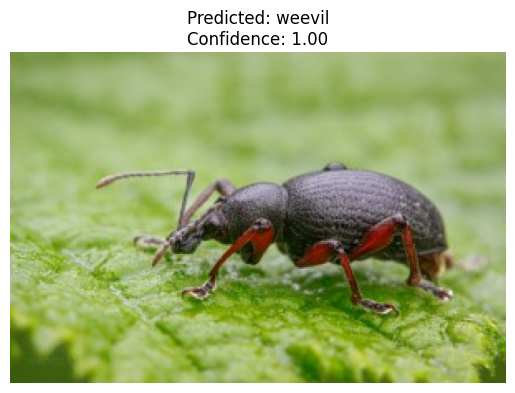

Predicted Pest: weevil
Confidence: 0.9997370839118958


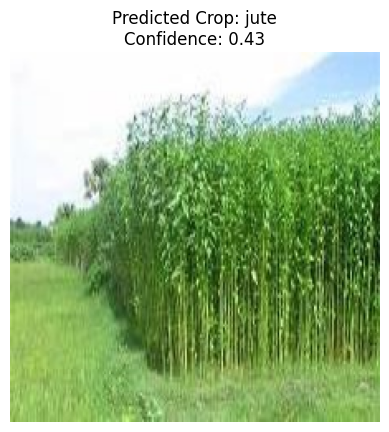

Predicted Crop: jute
Confidence: 0.4266096353530884
Human Suggestions:
- For pest 'weevil': Use neem-based sprays and remove affected plant parts.
- For crop 'jute': Maintain moderate irrigation; mulch to retain moisture.
- Ensure timely inspection and record keeping.

IoT Device Signals:
sprayer: False
irrigation: True
alert: True
light: False


In [ ]:
image_path1_1 = "/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/Weevil (283).jpg"
image_path2_1 = "/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/jute001a.jpeg"

predictedAgriPest, conf = predict_agriPest(
    image_path=image_path1_1,
    model=modelAgriculturePest,
    feature_extractor=feature_extractorAgri,
    device=device,
    show=True
)

print("Predicted Pest:", predictedAgriPest)
print("Confidence:", conf)




predictedCrop, conf = predict_crop(
    image_path=image_path2_1,
    model=modelCrop,
    feature_extractor=feature_extractorCrop,  # ✅ correct name
    device=device,
    show=True
)

print("Predicted Crop:", predictedCrop)
print("Confidence:", conf)

decision = LLMmodule(predictedAgriPest, predictedCrop)

print("Human Suggestions:")
for s in decision["human_suggestions"]:
    print("-", s)

print("\nIoT Device Signals:")
for dev, signal in decision["IoT_signals"].items():
    print(f"{dev}: {signal}")

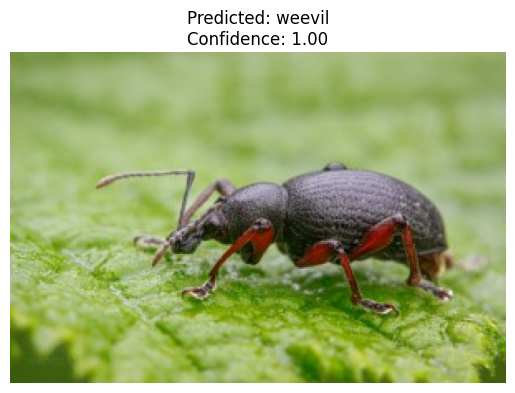

Predicted Pest: weevil
Confidence: 0.9997370839118958


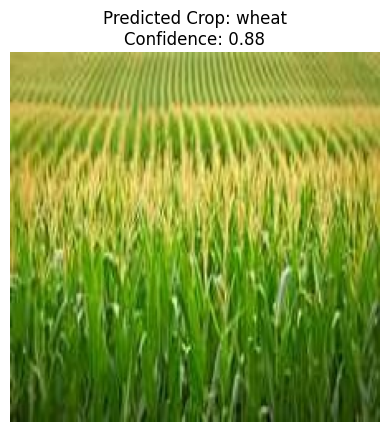

Predicted Crop: wheat
Confidence: 0.8761929273605347
Human Suggestions:
- For pest 'weevil': Use neem-based sprays and remove affected plant parts.
- For crop 'wheat': Maintain soil fertility; monitor for aphids.
- Ensure timely inspection and record keeping.

IoT Device Signals:
sprayer: False
irrigation: False
alert: True
light: False


In [ ]:
image_path1_1 = "/content/drive/MyDrive/AgriculturalPests/checkAgri/testimage/Weevil (283).jpg"
image_path2_1 = "/content/drive/MyDrive/AgriculturalPests/checkAgri/cropimage/maize001a.jpeg"

predictedAgriPest, conf = predict_agriPest(
    image_path=image_path1_1,
    model=modelAgriculturePest,
    feature_extractor=feature_extractorAgri,
    device=device,
    show=True
)

print("Predicted Pest:", predictedAgriPest)
print("Confidence:", conf)




predictedCrop, conf = predict_crop(
    image_path=image_path2_1,
    model=modelCrop,
    feature_extractor=feature_extractorCrop,  # ✅ correct name
    device=device,
    show=True
)

print("Predicted Crop:", predictedCrop)
print("Confidence:", conf)

decision = LLMmodule(predictedAgriPest, predictedCrop)

print("Human Suggestions:")
for s in decision["human_suggestions"]:
    print("-", s)

print("\nIoT Device Signals:")
for dev, signal in decision["IoT_signals"].items():
    print(f"{dev}: {signal}")

In [ ]:
counter = 1

for pest_img in agri_images:
    for crop_img in crop_images:
        print(f'image_path1_{counter} = "{pest_img}"')
        print(f'image_path2_{counter} = "{crop_img}"\n')

        predictedAgriPest, conf = predict_agriPest(image_path=pest_img,
        model=modelAgriculturePest,
        feature_extractor=feature_extractorAgri,
        device=device,
        show=True)

        print("Predicted Pest:", predictedAgriPest)
        print("Confidence:", conf)

        predictedCrop, conf = predict_crop(
        image_path=crop_img,
        model=modelCrop,
        feature_extractor=feature_extractorCrop,  # ✅ correct name
        device=device,    show=True)

        print("Predicted Crop:", predictedCrop)
        print("Confidence:", conf)

        decision = LLMmodule(predictedAgriPest, predictedCrop)

        print("Human Suggestions:")
        for s in decision["human_suggestions"]:
            print("-", s)

        print("\nIoT Device Signals:")
        for dev, signal in decision["IoT_signals"].items():
            print(f"{dev}: {signal}")

Output hidden; open in https://colab.research.google.com to view.

In [1]:
!pip install -q -U langchain langchain-core langchain-community google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.2/490.2 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [7]:
import google.generativeai as genai
from langchain_core.prompts import PromptTemplate

# -----------------------------
# ✅ 1. Configure your Gemini Pro API key
MY_KEY = "key here"  # <-- Your key
genai.configure(api_key=MY_KEY)

# -----------------------------
# ✅ 2. Check available models
print("Checking available models...")
available_models = [m.name for m in genai.list_models() if 'generateContent' in m.supported_generation_methods]
print(f"Your key can see: {available_models[:3]}... (and more)")

# -----------------------------
# ✅ 3. Main Function using Gemini Pro
def ask_gemini(q, predictedAgriPest, predictedCrop, model_name="gemini-2.5-flash"):
    """
    Sends a pest and crop to Gemini Pro and returns human suggestions + IoT signals.
    """
    model = genai.GenerativeModel(model_name)
    print("Predicted Agriculture Pest: " + predictedAgriPest)
    print("Predicted Crop: " + predictedCrop)

    # Updated prompt
    template = f"""
You are an AI agricultural assistant.
A pest and a crop have been identified in a field.
Provide actionable suggestions for a human and IoT device signals.

Inputs:
- Pest: {predictedAgriPest}
- Crop: {predictedCrop}
- Question: {q}

Rules:
- If the pest is harmful to this crop, suggest pest management steps.
- If the pest is beneficial, suggest monitoring only.
- Include crop-specific care or irrigation recommendations.
- Provide IoT device signals as True/False for sprayer, irrigation, alert.

Output format:
Human Suggestions:
- Suggestion 1
- Suggestion 2
IoT Device Signals:
- sprayer: True/False
- irrigation: True/False
- alert: True/False
"""

    try:
        response = model.generate_content(template)
        return response.text
    except Exception as e:
        return f"Error: {e}"

# -----------------------------
# ✅ Run the test with constants
print("\n--- Result ---")
predicted_response = ask_gemini("Give answer", predictedAgriPest="ants", predictedCrop="rice")
print(predicted_response)


Checking available models...
Your key can see: ['models/gemini-2.5-flash', 'models/gemini-2.5-pro', 'models/gemini-2.0-flash-exp']... (and more)

--- Result ---
Predicted Agriculture Pest: ants
Predicted Crop: rice
Human Suggestions:
- **Monitor Ant Activity and Associated Pests:** Carefully observe the ants. Are they directly damaging rice seedlings or seeds? More commonly, ants in rice fields might be tending to other sap-sucking pests (like aphids, mealybugs, or planthoppers) for their honeydew. Look closely at the rice plants, especially stems and undersides of leaves, for signs of these secondary pests.
- **Maintain Optimal Water Management:** Ensure proper flood irrigation for your rice crop. Consistent water levels are crucial for rice health and can also deter some ant species or disrupt their nests if they are ground-dwelling.
- **Assess Direct vs. Indirect Impact:** If ants are not tending other pests and are not causing direct damage (e.g., disturbing newly sown seeds), they

In [27]:
# ✅ Run the test with constants
print("\n--- Result ---")
predictedAgriPest="snail"
predictedCrop="jute"

question=input("Predicted Pest: " + predictedAgriPest + " \npredictedCrop:" + predictedCrop + " \nEnter Your Question ")
print("\n--- Result ---")
predicted_response = ask_gemini(question, predictedAgriPest, predictedCrop)
print(predicted_response)


--- Result ---
Predicted Pest: snail 
predictedCrop:jute 
Enter Your Question what could be the next

--- Result ---
Predicted Agriculture Pest: snail
Predicted Crop: jute
Human Suggestions:
-   **Pest Management (Snails):**
    1.  **Manual Removal & Sanitation:** Regularly inspect jute plants, especially in the early morning or evening, and hand-pick snails. Remove any plant debris, weeds, and excess leaf litter from around the jute field, as these provide excellent hiding spots for snails.
    2.  **Improve Drainage:** Ensure good field drainage to reduce overly damp conditions that snails prefer. While jute needs moisture, standing water or continuously soggy soil creates an ideal environment for snails.
    3.  **Barrier Methods:** For smaller plots or vulnerable young plants, consider creating physical barriers such as a band of diatomaceous earth, crushed eggshells, or copper tape around the base of the jute plants.
    4.  **Trapping:** Deploy simple traps like shallow dishes 

In [4]:
# -----------------------------
# Define classes
class_namesA = [
    'ants', 'earthworms', 'earwig', 'grasshopper',
    'moth', 'snail', 'wasp', 'weevil'
]

crop_class_names = [
    "jute",
    "maize",
    "rice",
    "sugarcane",
    "wheat"
]

# -----------------------------
# Generate all 40 pairs
pairs = []
for pest in class_namesA:
    for crop in crop_class_names:
        pairs.append((pest, crop))

# -----------------------------
# Print them
for i, (pest, crop) in enumerate(pairs, 1):
    print(f"Pair {i}: predictedAgriPest = '{pest}', predictedCrop = '{crop}'")



Pair 1: predictedAgriPest = 'ants', predictedCrop = 'jute'
Pair 2: predictedAgriPest = 'ants', predictedCrop = 'maize'
Pair 3: predictedAgriPest = 'ants', predictedCrop = 'rice'
Pair 4: predictedAgriPest = 'ants', predictedCrop = 'sugarcane'
Pair 5: predictedAgriPest = 'ants', predictedCrop = 'wheat'
Pair 6: predictedAgriPest = 'earthworms', predictedCrop = 'jute'
Pair 7: predictedAgriPest = 'earthworms', predictedCrop = 'maize'
Pair 8: predictedAgriPest = 'earthworms', predictedCrop = 'rice'
Pair 9: predictedAgriPest = 'earthworms', predictedCrop = 'sugarcane'
Pair 10: predictedAgriPest = 'earthworms', predictedCrop = 'wheat'
Pair 11: predictedAgriPest = 'earwig', predictedCrop = 'jute'
Pair 12: predictedAgriPest = 'earwig', predictedCrop = 'maize'
Pair 13: predictedAgriPest = 'earwig', predictedCrop = 'rice'
Pair 14: predictedAgriPest = 'earwig', predictedCrop = 'sugarcane'
Pair 15: predictedAgriPest = 'earwig', predictedCrop = 'wheat'
Pair 16: predictedAgriPest = 'grasshopper', pred

In [5]:
for i, (pest, crop) in enumerate(pairs, 1):
    predictedAgriPest = pest
    predictedCrop = crop
    print("\n==========================================================================================")
    predicted_response = ask_gemini(predictedAgriPest, predictedCrop)
    print(predicted_response)



Predicted Agriculture Pest: ants
Predicted Crop: jute
Human Suggestions:
- **Thorough Field Inspection:** Carefully inspect the jute plants, especially the undersides of leaves, stems, and growing tips, for the presence of other common jute pests such as aphids, mealybugs, or scale insects. Ants often "farm" these pests for their honeydew secretions. Identifying the primary pest, if any, is crucial.
- **Implement Targeted Pest Management (if primary pests found):** If aphids or other honeydew-producing pests are identified, focus pest management efforts on controlling these primary pests. Managing the primary pest population will typically cause the ants to disperse naturally. Consider biological control (e.g., introducing ladybugs, lacewings) or appropriate organic insecticides if necessary.
- **Maintain Optimal Jute Irrigation:** Jute is a water-intensive crop and requires consistent moisture, particularly during its active growth phases. Ensure the soil remains adequately moist but

Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 49.739948475s.

Predicted Agriculture Pest: earwig
Predicted Crop: rice


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 49.225591137s.

Predicted Agriculture Pest: earwig
Predicted Crop: sugarcane


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 48.731553557s.

Predicted Agriculture Pest: earwig
Predicted Crop: wheat


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 48.220185728s.

Predicted Agriculture Pest: grasshopper
Predicted Crop: jute


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 47.717224725s.

Predicted Agriculture Pest: grasshopper
Predicted Crop: maize


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 47.208153769s.

Predicted Agriculture Pest: grasshopper
Predicted Crop: rice


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 46.692380418s.

Predicted Agriculture Pest: grasshopper
Predicted Crop: sugarcane


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 46.204368298s.

Predicted Agriculture Pest: grasshopper
Predicted Crop: wheat


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 45.718454174s.

Predicted Agriculture Pest: moth
Predicted Crop: jute


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 45.22142981s.

Predicted Agriculture Pest: moth
Predicted Crop: maize


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 44.719484648s.

Predicted Agriculture Pest: moth
Predicted Crop: rice


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 44.234598338s.

Predicted Agriculture Pest: moth
Predicted Crop: sugarcane


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 43.733244966s.

Predicted Agriculture Pest: moth
Predicted Crop: wheat


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 43.214745171s.

Predicted Agriculture Pest: snail
Predicted Crop: jute


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 42.571090647s.

Predicted Agriculture Pest: snail
Predicted Crop: maize


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 42.049543956s.

Predicted Agriculture Pest: snail
Predicted Crop: rice


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 41.536901482s.

Predicted Agriculture Pest: snail
Predicted Crop: sugarcane


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 41.023216839s.

Predicted Agriculture Pest: snail
Predicted Crop: wheat


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 40.539076427s.

Predicted Agriculture Pest: wasp
Predicted Crop: jute


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 40.030686927s.

Predicted Agriculture Pest: wasp
Predicted Crop: maize


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 39.53210046s.

Predicted Agriculture Pest: wasp
Predicted Crop: rice


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 39.010363369s.

Predicted Agriculture Pest: wasp
Predicted Crop: sugarcane


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 38.526896427s.

Predicted Agriculture Pest: wasp
Predicted Crop: wheat


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 38.009945388s.

Predicted Agriculture Pest: weevil
Predicted Crop: jute


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 37.526135496s.

Predicted Agriculture Pest: weevil
Predicted Crop: maize


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 37.026785006s.

Predicted Agriculture Pest: weevil
Predicted Crop: rice


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 36.519250621s.

Predicted Agriculture Pest: weevil
Predicted Crop: sugarcane


Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 36.039735009s.

Predicted Agriculture Pest: weevil
Predicted Crop: wheat
Error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. 
* Quota exceede